In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import json
import pickle

In [2]:
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt

In [3]:
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

In [4]:
%%time
with open("./fundamentals_SP500.json", "r") as fin:
    fundamentals = json.load(fin)

CPU times: total: 1.31 s
Wall time: 2.03 s


In [96]:
sym = "AAPL"
df = pd.json_normalize(
        fundamentals[sym]['Financials']["Balance_Sheet"]["quarterly"].values(),   
)

In [97]:
df["date"] = pd.to_datetime(df["date"])
df["quarter"] = pd.to_datetime(df["date"].dt.to_period("Q").dt.strftime("%YQ%q"))

In [98]:
# pandas_profiling.ProfileReport(df, interactions=None).to_file("./sp500_bs_q.html")

In [99]:
cols = [
          #"totalStockholderEquity",
          "totalAssets", "totalLiab",
          "totalCurrentAssets", "totalCurrentLiabilities", 
         ]

In [100]:
diff = df.set_index("quarter")[cols].astype(float)\
        .pct_change(1).iloc[1:, :]\
        .sort_index()
diff.index = pd.DatetimeIndex(diff.index, freq="QS")

train = diff.loc["2014-12-31": "2020-12-31"]
test = diff.loc["2020-12-31":]

In [101]:
len(train), len(test)

(24, 5)

In [102]:
n_forecast = len(test)

In [103]:
train.head()

,totalAssets,totalLiab,totalCurrentAssets,totalCurrentLiabilities
quarter,,,,
2015-01-01,-0.043774,-0.103652,-0.043155,-0.100421
2015-04-01,-0.059653,-0.138204,-0.206147,-0.190113
2015-07-01,-0.009564,0.037008,0.172647,0.059375
2015-10-01,-0.039286,-0.056075,-0.129841,0.114656
2016-01-01,-0.001063,-0.023685,-0.065795,-0.045058


# VAR model

In [104]:
m = sm.VAR(train)
rst = m.fit(2)
rst.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Oct, 2022
Time:                     10:05:29
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -22.7216
Nobs:                     22.0000    HQIC:                  -24.0863
Log likelihood:           180.710    FPE:                2.78693e-11
AIC:                     -24.5069    Det(Omega_mle):     7.06920e-12
--------------------------------------------------------------------
Results for equation totalAssets
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                              0.013470         0.022157            0.608           0.543
L1.totalAssets                     0.488600         0.701696            0.696           0.486
L1

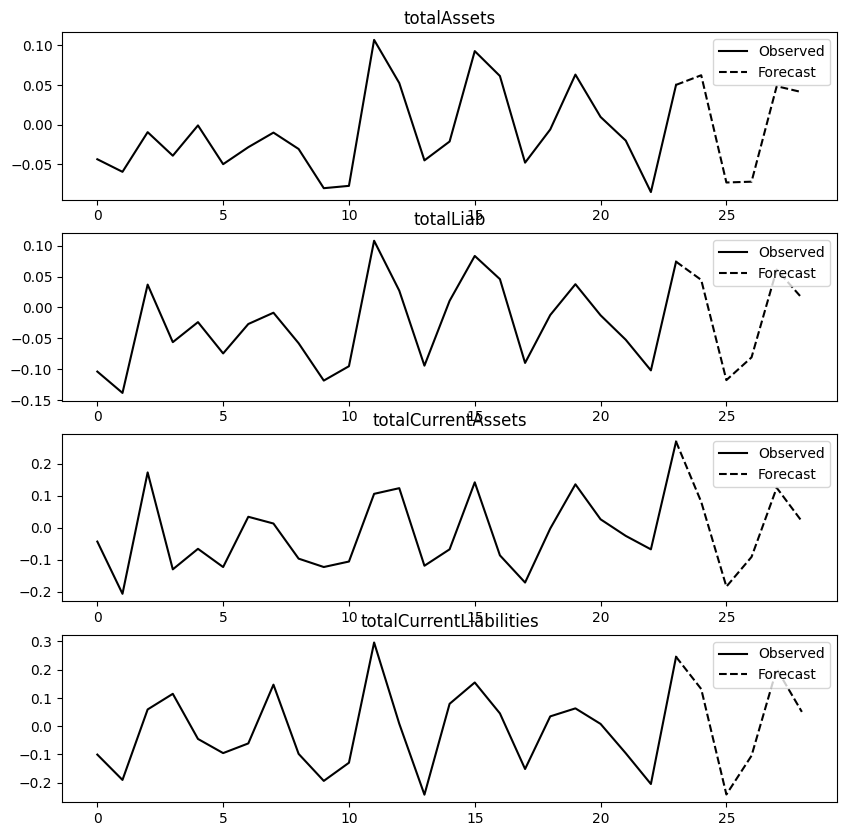

In [105]:
rst.plot_forecast(n_forecast, plot_stderr=False);

In [111]:
yhat_var = rst.forecast(train.iloc[-2:].to_numpy(), n_forecast)

In [107]:
# MAE for each variable
abs(yhat_var - test).mean()

totalAssets                0.020072
totalLiab                  0.024056
totalCurrentAssets         0.056772
totalCurrentLiabilities    0.080863
dtype: float64

# ARIMA model

In [108]:
m_arima = {}
MAE_arima = {}
for c in train.columns:
    arima = sm.arima.ARIMA(train[c], order=(2, 1, 2))
    res = arima.fit()
    
    m_arima[c] = res
    mae = abs(res.forecast(n_forecast)-test[c]).mean()
    
    MAE_arima[c] = mae

C:\Users\Francis\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [109]:
# ARIMA model
pd.Series(MAE_arima)

totalAssets                0.028101
totalLiab                  0.035019
totalCurrentAssets         0.117696
totalCurrentLiabilities    0.065282
dtype: float64

In [112]:
# MAE for each variable
abs(yhat_var - test).mean()

totalAssets                0.020072
totalLiab                  0.024056
totalCurrentAssets         0.056772
totalCurrentLiabilities    0.080863
dtype: float64

In [110]:
# MAE for prediction with mean of train set
abs(test-train.mean()).mean()

totalAssets                0.060120
totalLiab                  0.058487
totalCurrentAssets         0.139591
totalCurrentLiabilities    0.087860
dtype: float64